![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import ast

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

from sklearn import linear_model, decomposition, datasets
from sklearn.preprocessing import StandardScaler

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('data_movies/dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('data_movies/dataTesting.csv', encoding='UTF-8', index_col=0)

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,"most is the story of a single father who takes his eight year - old son to work with him at the railroad drawbridge where he is the bridge tender . a day before , the boy meets a woman boarding a train , a drug abuser . at the bridge , the father goes into the engine room , and tells his s...","['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets of his satisfying career to a video store clerk .,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfiguring facial scar meets a gentleman who lives beyond his means . they become accomplices in blackmail , and she falls in love with him , bitterly resigned to the impossibility of his returning her affection . her life changes when one of her vic...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the president of the tredway corporation avery bullard has just had a meeting with investment bankers and sends a telegram scheduling a meeting at the furniture factory in millburgh , pennsylvania , at six pm with his executives . bullard has never appoint...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing house carol hunnicut goes to a blind date with the lawyer michael tarlow , who has embezzled the powerful mobster leo watts . carol accidentally witnesses the murder of michel by leo ' s hitman . the scared carol sneaks out of michael ' s room and ...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate . theresa osborne is running along the beach when she stumbles upon a bottle washed up on the shore . inside is a message , reading the letter she feels so moved and yet she felt as if she has violated someone ' s thoughts . in love with a man she..."
4,1978,Midnight Express,"the true story of billy hayes , an american college student who is caught smuggling drugs out of turkey and thrown into prison ."
5,1996,Primal Fear,"martin vail left the chicago da ' s office to become a successful criminal lawyer , that success predicated on working on high profile cases . as such , he fights to get the case of naive nineteen year old rural kentuckian aaron stampler , an altar boy accused of the vicious bludgeoning deat..."
6,1950,Crisis,"husband and wife americans dr . eugene and mrs . helen ferguson - he a renowned neurosurgeon - are traveling through latin america for a vacation . when they make the decision to return to new york earlier than expected , they find they are being detained by the military in the country t..."
7,1959,The Tingler,"the coroner and scientist dr . warren chapin is researching the shivering effect of fear with his assistant david morris . dr . warren is introduced to ollie higgins , the relative of a criminal sentenced to the electric chair , while making the autopsy of the corpse , and he makes a comme..."


#### Exploratory data analysis

In [6]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7895 entries, 3107 to 215
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    7895 non-null   int64  
 1   title   7895 non-null   object 
 2   plot    7895 non-null   object 
 3   genres  7895 non-null   object 
 4   rating  7895 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 370.1+ KB


In [7]:
dataTraining.isnull().sum()

year      0
title     0
plot      0
genres    0
rating    0
dtype: int64

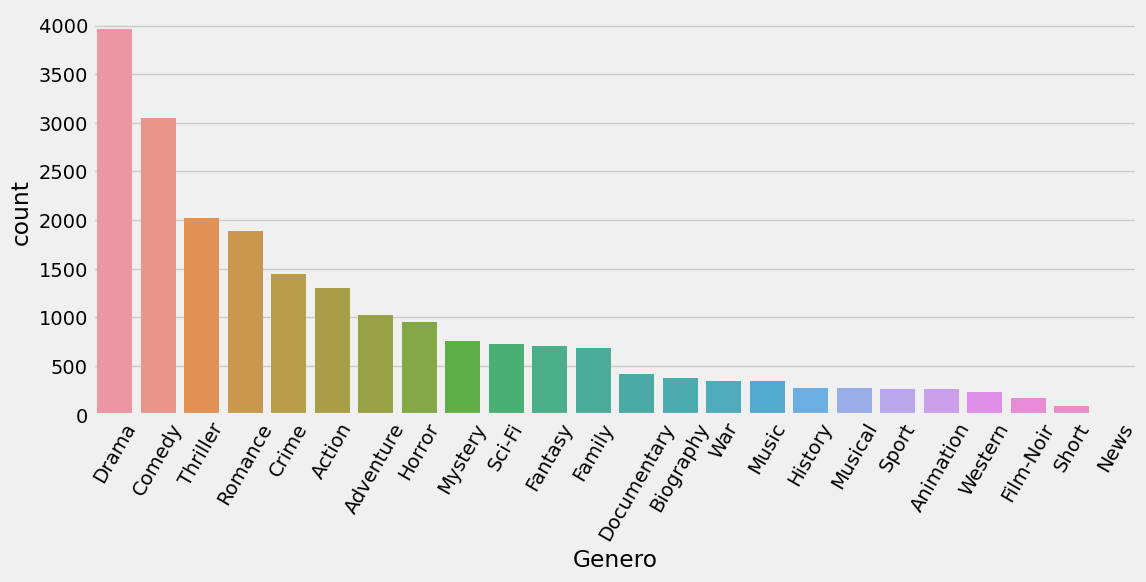

In [8]:
generos = []

for i in dataTraining['genres']:
    list_genres = ast.literal_eval(i)
    for j in list_genres:
        generos.append(j)

df_gen = pd.DataFrame(generos, columns=['Genero'])        
df_gen

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
sns.countplot(x='Genero',data=df_gen, order = df_gen['Genero'].value_counts().index)    # Count of number of descriptions for each class label
plt.xticks(rotation=60)
plt.show()

In [9]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [10]:
dataTraining['clean_plot'] = dataTraining['plot'].apply(lambda x: clean_text(x))
dataTesting['clean_plot'] = dataTesting['plot'].apply(lambda x: clean_text(x))

In [11]:
# Outliers
dataTraining['clean_plot_length']=dataTraining['clean_plot'].apply(lambda x:len(x))  # calculate length of cleaned text
dataTraining.head()

(dataTraining['clean_plot_length']>1504).value_counts()

# Remove extremely long descriptions: outliers
print('Dataframe size (before removal): ',len(dataTraining))
filt=dataTraining['clean_plot_length']>1504
dataTraining.drop(dataTraining[filt].index,axis=0,inplace=True)     # filter rows having cleaned description length > 2000
print('Dataframe size (after removal): ',len(dataTraining))
print(f'Removed rows: {filt.sum()}')

Dataframe size (before removal):  7895
Dataframe size (after removal):  7390
Removed rows: 505


In [12]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()

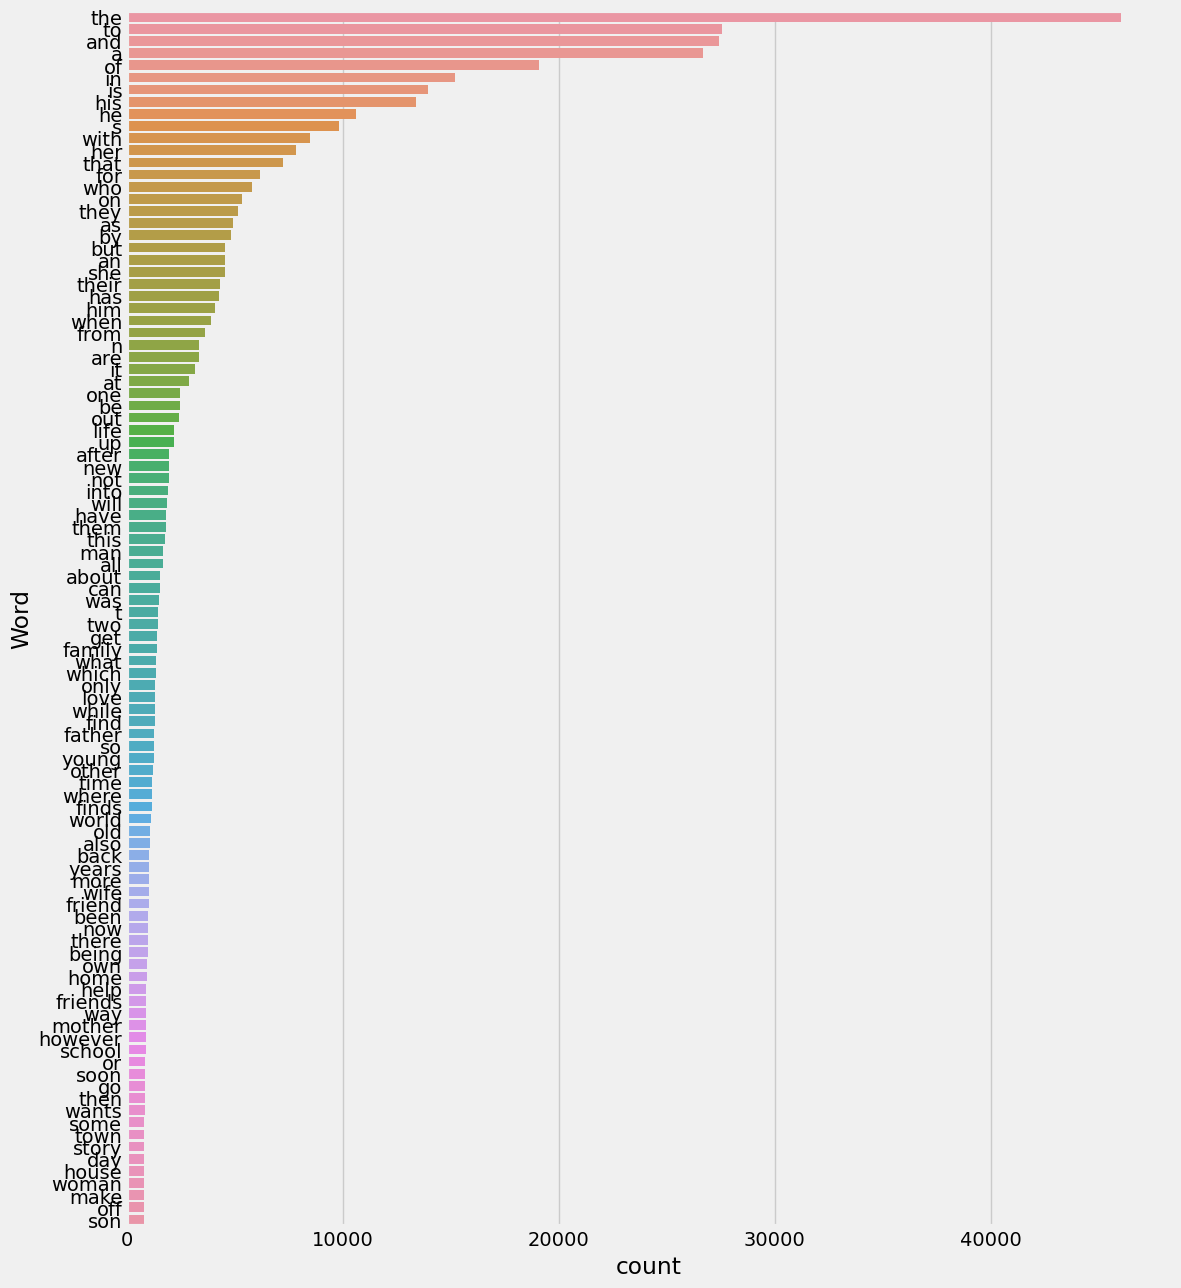

In [13]:
# print 100 most frequent words 
freq_words(dataTraining['clean_plot'], 100)

In [14]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

dataTraining['clean_plot'] = dataTraining['clean_plot'].apply(lambda x: remove_stopwords(x))
dataTesting['clean_plot'] = dataTesting['clean_plot'].apply(lambda x: remove_stopwords(x))

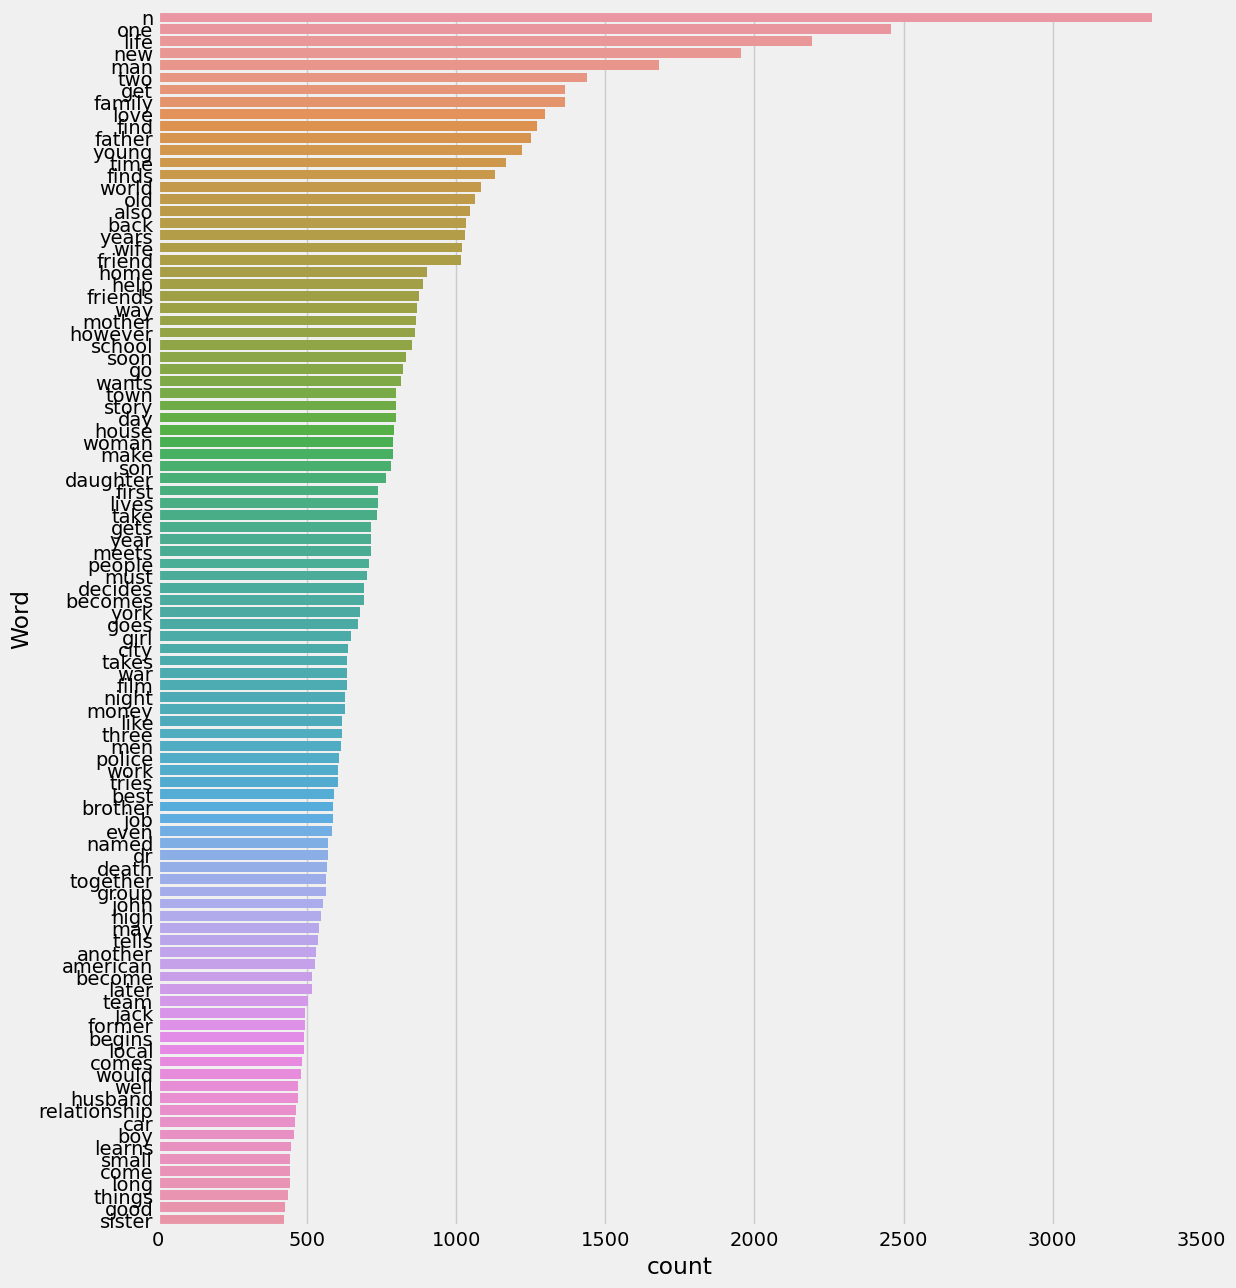

In [15]:
freq_words(dataTraining['clean_plot'], 100)

In [16]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y = le.fit_transform(dataTraining['genres'])

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, sublinear_tf=True, smooth_idf=False)

In [18]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(dataTraining['clean_plot'], y, test_size=0.2, random_state=9)

In [19]:
# plot list for testing microservice
plot_test_list = [fila for fila in xval.head(2)]

In [20]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

### Hyperparameter Tuning

In [21]:
# dict_params = {}
# max_mcauc = 0

# solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
# penalty = ['l1','l2','elasticnet']
# c_values = [100, 10, 1.0, 0.1, 0.01]

# for s in solver:
#     for p in penalty:
#         for c in c_values:
#             try:
#                 lr = LogisticRegression(solver=s, penalty=p, C=c, max_iter=100000, verbose=0)
#                 clf = OneVsRestClassifier(lr)
#                 clf.fit(xtrain_tfidf, ytrain)
#                 # predict probabilities
#                 y_pred_prob = clf.predict_proba(xval_tfidf)

#                 if max_mcauc == 0: 
#                     max_mcauc = round(roc_auc_score(yval, y_pred_prob, average='macro'),3)
#                     item = {'mcauc': max_mcauc, 'solver':s, 'penalty': p, 'c_values': c}
#                     dict_params.update(item)
#                 else:
#                     if round(roc_auc_score(yval, y_pred_prob, average='macro'),3) > max_mcauc:
#                         max_mcauc = round(roc_auc_score(yval, y_pred_prob, average='macro'),3)
#                         item = {'mcauc': max_mcauc, 'solver':s, 'penalty': p, 'c_values': c}
#                         dict_params.update(item)
#             except:
#                 pass

# print(f'Best Params: { dict_params }')

In [22]:
lr = LogisticRegression(solver='liblinear', penalty='l2')
clf = OneVsRestClassifier(lr)

In [23]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

In [24]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [25]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [26]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.5728853444894757

In [27]:
# # Impresión del desempeño del modelo
roc_auc_score(yval, y_pred_prob, average='macro')

0.9051273132814126

In [28]:
# transformación variables predictoras X del conjunto de test
X_test_dtm = tfidf_vectorizer.transform(dataTesting['clean_plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [29]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.125692,0.093733,0.037366,0.031377,0.370930,0.140061,0.037434,0.510903,0.074187,0.122537,...,0.033065,0.109298,0.001995,0.456928,0.060941,0.011409,0.027312,0.176000,0.028056,0.029470
4,0.119507,0.056009,0.030964,0.119751,0.259438,0.260902,0.064137,0.805479,0.041773,0.040737,...,0.031268,0.055235,0.002191,0.106534,0.030734,0.013084,0.034913,0.274386,0.048139,0.029539
5,0.119404,0.039022,0.017340,0.052149,0.153833,0.556457,0.032344,0.776158,0.033787,0.044167,...,0.022105,0.230558,0.002135,0.183736,0.044580,0.009997,0.026834,0.458977,0.034593,0.019009
6,0.122597,0.093811,0.025754,0.037651,0.195861,0.093087,0.031438,0.692089,0.059434,0.057198,...,0.032378,0.104888,0.001923,0.204266,0.131681,0.009821,0.032018,0.336754,0.052945,0.025995
7,0.080130,0.092739,0.031425,0.034885,0.266552,0.111855,0.045409,0.409621,0.060539,0.126744,...,0.026940,0.104380,0.002049,0.168477,0.266106,0.011444,0.020094,0.318161,0.022884,0.025564


### Inference Function

In [30]:
categories = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
        'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance',
        'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']

# Top 5 predicted categories 
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict_proba(q_vec)
    res = pd.DataFrame(q_pred, columns=categories, )
    final_df = res.T.sort_values(by=0, ascending=False).head(5)
    return final_df.index.tolist()

### Microservice

In [31]:
# Exportar modelo y vector a archivo binario .pkl
import joblib

joblib.dump(clf, 'model_deployment_movie/movie_genre_clf.pkl', compress=3)
joblib.dump(tfidf_vectorizer, 'model_deployment_movie/tfidf_vectorizer.pkl', compress=3)

['model_deployment_movie/tfidf_vectorizer.pkl']

In [32]:
for i in plot_test_list:
    print(i,'\n')

pat cappadora neurotic wife beth takes two boys along class reunion annex photography mission chicago makes n year old vincent watch keep pinned n year old ben acts sole victim ben goes missing neglects job household utterly keeps complaining even amazing neighborhood efforts find ben vain process neglected vincent helped pa raise youngest sibling place embitters starts going astray nine years later pat moves chicago set new restaurant chicago chance boy almost next door sam karras identified ben kidnapped late lovingly raised husband george karras families upset core repeatedly 

ever get want brian sells mattresses warehouse store father older brothers material success wants child applied adopt baby china man appears homeless seems stalking brian violent intent meets happy daughter rich quirky customer stick anything brian hit except vomiting learns adoption idea wants meet family call adoption happy 



In [33]:
# Importar modelo y predicción
from model_deployment_movie.model_deployment import predict

# Predicción
for i in plot_test_list:
    print(predict(i))

['Drama', 'Comedy', 'Thriller']
['Comedy', 'Drama', 'Romance']


### Make model available with Flask

In [34]:
# Importación librerías
from flask import Flask, render_template
from flask_restx import Api, Resource, fields

In [35]:
# Definición aplicación Flask
app = Flask(__name__)

# Definición API Flask
api = Api(
    app, 
    version='1.0', 
    title='Movie genre classification API',
    description='Movie genre classification API')

ns = api.namespace('Predict', 
     description='Top 3 Most Likely Movie Genres')

# Definición argumentos o parámetros de la API
parser = api.parser()

parser.add_argument(
    'PLOT', 
    type=str, 
    required=True, 
    help='Plot', 
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.String
})

In [36]:
# Definición de la clase para disponibilización
@ns.route('/')
class MovieGenreApi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
         "result": predict(args['PLOT'])
        }, 200

In [ ]:
# Ejecución de la aplicación que disponibiliza el modelo de manera local en el puerto 5000
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on all addresses.
 * Running on http://192.168.1.4:5000/ (Press CTRL+C to quit)
192.168.1.4 - - [21/May/2023 19:12:41] "GET / HTTP/1.1" 200 -
192.168.1.4 - - [21/May/2023 19:12:41] "GET /swagger.json HTTP/1.1" 200 -
192.168.1.4 - - [21/May/2023 19:12:48] "GET /Predict/?PLOT=ever%20get%20want%20brian%20sells%20mattresses%20warehouse%20store%20father%20older%20brothers%20material%20success%20wants%20child%20applied%20adopt%20baby%20china%20man%20appears%20homeless%20seems%20stalking%20brian%20violent%20intent%20meets%20happy%20daughter%20rich%20quirky%20customer%20stick%20anything%20brian%20hit%20except%20vomiting%20learns%20adoption%20idea%20wants%20meet%20family%20call%20adoption%20happy%20 HTTP/1.1" 200 -
